In [1]:
path = "/content/drive/MyDrive/ColabNotebooks/PROGS/M_LSTM_AE"

%cd {path}

/content/drive/MyDrive/ColabNotebooks/PROGS/M_LSTM_AE


In [2]:
# Libs

import numpy as np
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

Start date is:  1999-01-04 00:00:00
End date is:  2023-10-24 00:00:00
['Open', 'High', 'Low', 'Close', 'Adj Close']


<Axes: xlabel='Date', ylabel='Open'>

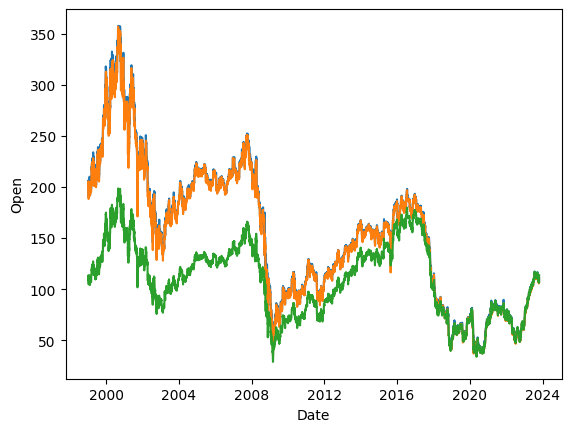

In [3]:
# Import data

data = pd.read_csv('data/GE.csv')

# Separate dates for future plotting
train_dates = pd.to_datetime(data['Date'].copy())
print("Start date is: ", train_dates[0])
print("End date is: ", train_dates[len(train_dates)-1])

# Variables for training
cols = list(data)[1:6]
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']
!
df = data[cols]

sns.lineplot(x=train_dates, y=df['Open'])
sns.lineplot(x=train_dates, y=df['Low'])
sns.lineplot(x=train_dates, y=df['Adj Close'])

In [4]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df = scaler.transform(df)

# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training).
trainX = []
trainY = []
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.
# Reformat input data into a shape: (n_samples x timesteps x n_features)
# In my example, my df_for_training_scaled has a shape (12823, 5)
# 12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df) - n_future +1):
    trainX.append(df[i - n_past:i, 0:df.shape[1]])
    trainY.append(df[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (6229, 14, 5).
trainY shape == (6229, 1).


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 128)           68608     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118081 (461.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


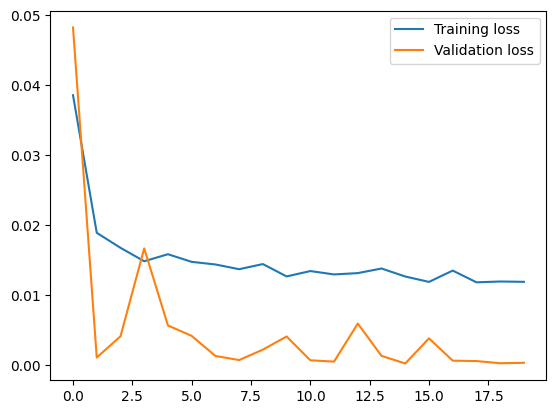

In [6]:
# Model 1
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=0)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [7]:
# Predicting

# Libraries that will help us extract only business days in the US.
# Otherwise our dates would be wrong when we look back (or forward).
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction = 15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2023-10-03 00:00:00', freq='C'), Timestamp('2023-10-04 00:00:00', freq='C'), Timestamp('2023-10-05 00:00:00', freq='C'), Timestamp('2023-10-06 00:00:00', freq='C'), Timestamp('2023-10-10 00:00:00', freq='C'), Timestamp('2023-10-11 00:00:00', freq='C'), Timestamp('2023-10-12 00:00:00', freq='C'), Timestamp('2023-10-13 00:00:00', freq='C'), Timestamp('2023-10-16 00:00:00', freq='C'), Timestamp('2023-10-17 00:00:00', freq='C'), Timestamp('2023-10-18 00:00:00', freq='C'), Timestamp('2023-10-19 00:00:00', freq='C'), Timestamp('2023-10-20 00:00:00', freq='C'), Timestamp('2023-10-23 00:00:00', freq='C'), Timestamp('2023-10-24 00:00:00', freq='C')]


In [8]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
print(prediction_copies.shape)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 [==============================] - 0s 232ms/step
(15, 5)


<ipython-input-9-19a00621cf48>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

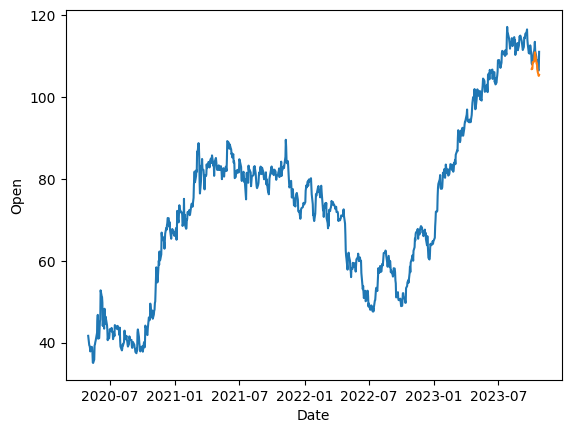

In [9]:
 # Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = data[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(x=original['Date'], y=original['Open'])
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'])

1/1 [==============================] - 0s 60ms/step
pred: [[106.86017  108.01397  105.58003  106.783035  84.95443 ]
 [106.9795   108.134575 105.6981   106.902466  85.01733 ]
 [106.92095  108.0754   105.640175 106.84387   84.986465]
 [108.54128  109.71312  107.243416 108.46552   85.84051 ]
 [108.67124  109.844475 107.372    108.59559   85.909004]
 [109.7028   110.8871   108.39268  109.62798   86.452705]
 [110.94271  112.14033  109.619514 110.86891   87.10624 ]
 [110.45492  111.64729  109.13686  110.38072   86.84914 ]
 [108.90413  110.079865 107.60243  108.82867   86.03175 ]
 [108.10535  109.27251  106.81208  108.029236  85.61073 ]
 [108.175186 109.3431   106.88118  108.09913   85.647545]
 [106.942795 108.09747  105.66178  106.86573   84.99798 ]
 [106.163605 107.30992  104.89081  106.0859    84.58729 ]
 [105.16503  106.30063  103.90277  105.08652   84.06097 ]
 [105.425224 106.56362  104.16022  105.346924  84.198105]]
Forecasted values for High:
Date: 2023-10-03, Value: 106.86016845703125

<ipython-input-10-ba2bec26fb38>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


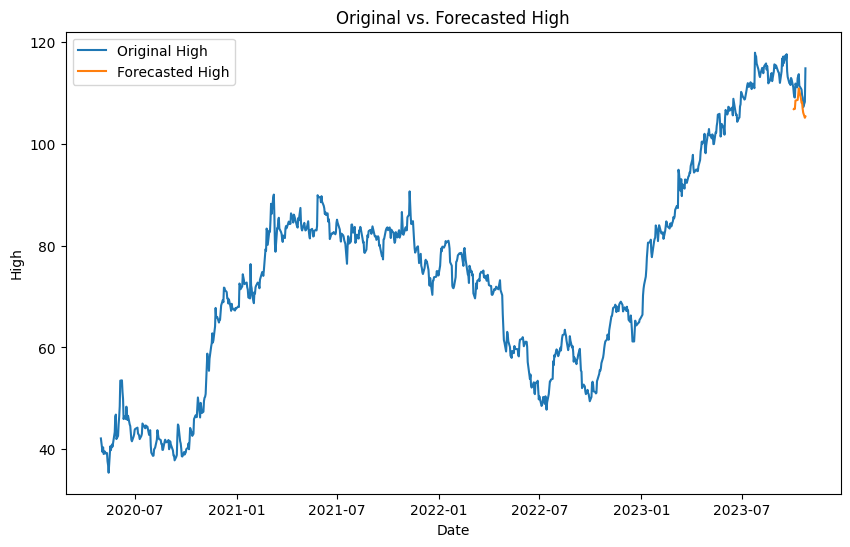

<ipython-input-10-ba2bec26fb38>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


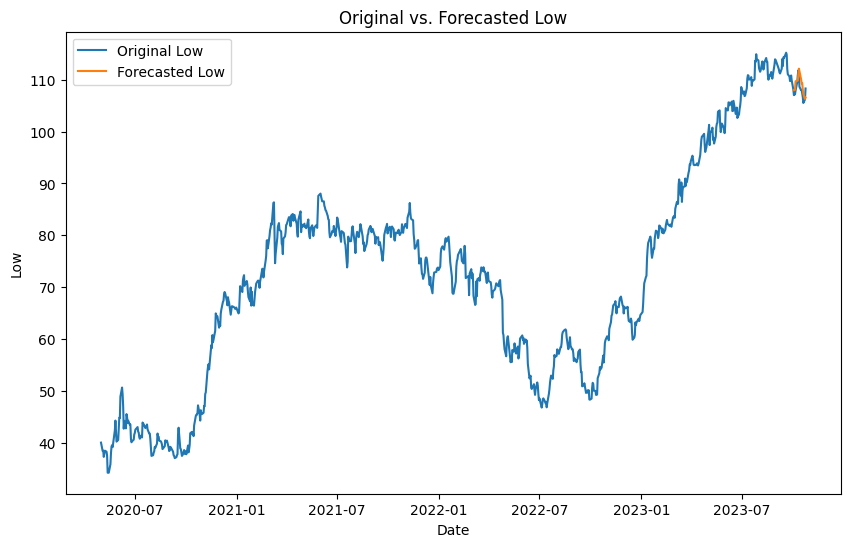

<ipython-input-10-ba2bec26fb38>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


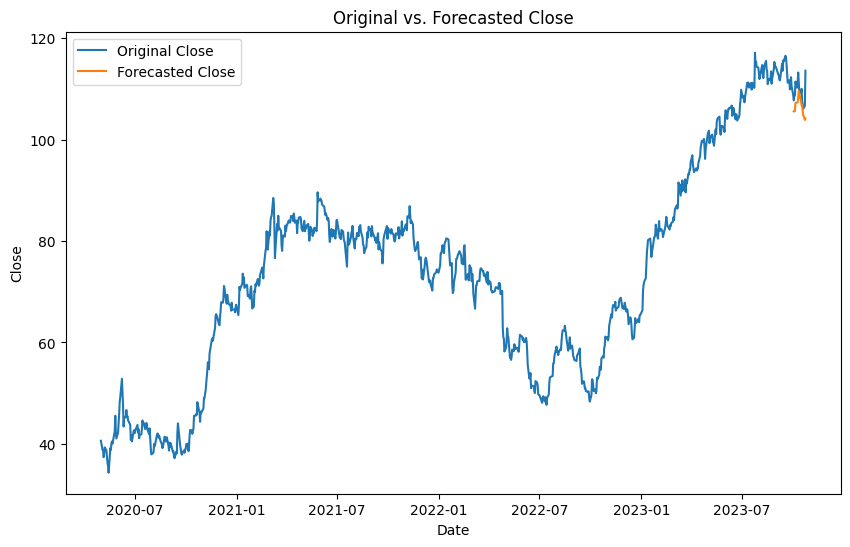

<ipython-input-10-ba2bec26fb38>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


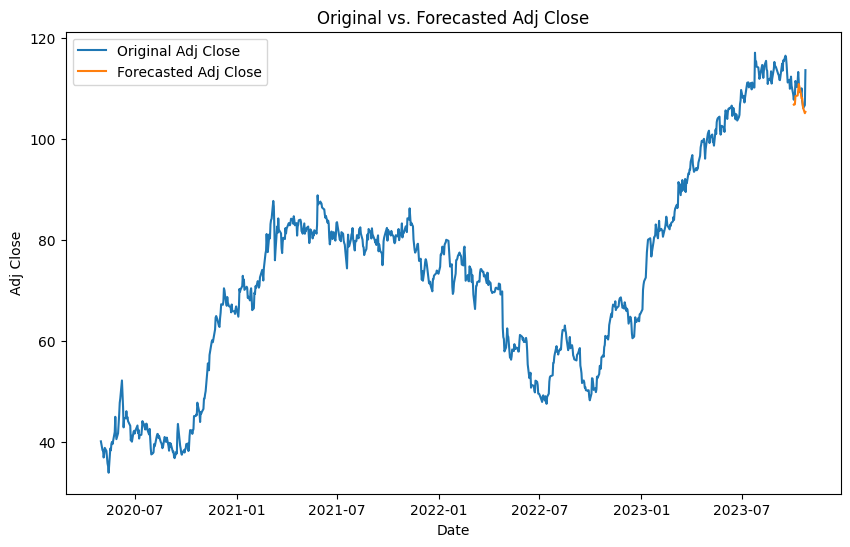

In [10]:
# Make predictions for all parameters
prediction = model.predict(trainX[-n_days_for_prediction:])


# Inverse transformation for all parameters
prediction_copies = np.repeat(prediction, df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)
print("pred:", y_pred_future)

forecast_data = {}
forecast_columns = ['High', 'Low', 'Close', 'Adj Close']

for i, parameter in enumerate(forecast_columns):
    y_pred_parameter = y_pred_future[:, i]
    forecast_dates = [time_i.date() for time_i in predict_period_dates]

    # Create a DataFrame for the parameter
    forecast_data[parameter] = pd.DataFrame({'Date': forecast_dates, parameter: y_pred_parameter})
    forecast_data[parameter]['Date'] = pd.to_datetime(forecast_data[parameter]['Date'])

    # Print the forecasted values for the parameter
    print(f'Forecasted values for {parameter}:')
    for date, value in zip(forecast_dates, y_pred_parameter):
        print(f'Date: {date}, Value: {value}')

# Plot the original and forecasted data for all parameters
for parameter, forecast_df in forecast_data.items():
    original = data[['Date', parameter]]
    original['Date'] = pd.to_datetime(original['Date'])
    original = original.loc[original['Date'] >= '2020-05-01']

    plt.figure(figsize=(10, 6))
    plt.plot(original['Date'], original[parameter], label=f'Original {parameter}')
    plt.plot(forecast_df['Date'], forecast_df[parameter], label=f'Forecasted {parameter}')
    plt.xlabel('Date')
    plt.ylabel(parameter)
    plt.title(f'Original vs. Forecasted {parameter}')
    plt.legend()
    plt.show()
